In [2]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

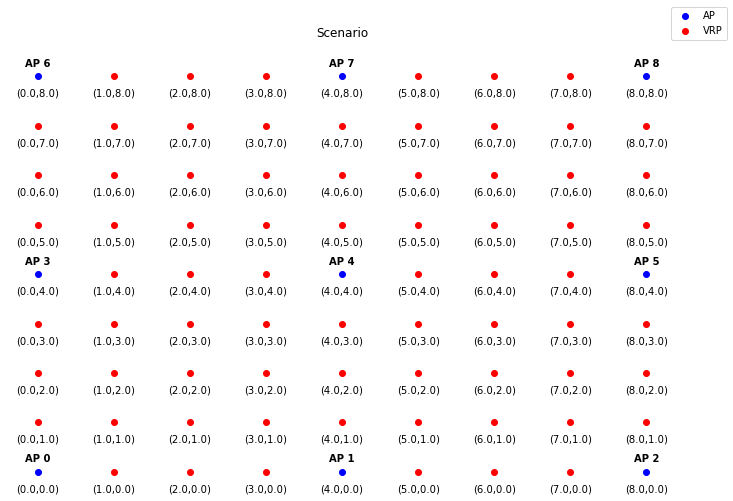

In [3]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1,2)

# ----------------------------------------------------------------------
#  AP locations
L_ap = locations[[0,4,8,36,40,44,72,76,80],:]
L_ap[:, [1, 0]] = L_ap[:, [0, 1]]

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)
L_vrp[:, [1, 0]] = L_vrp[:, [0, 1]]

plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Scenario',pad=20)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [4]:
"""
Compute Euclidean distance between APs
    
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance(array):
    n = array.shape[0]

    d_mat = [np.linalg.norm(i - j) for (i,j) in itertools.product(array, array)]
    d_mat = np.array(d_mat).reshape(n, n)

    return d_mat

In [5]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance(L_ap)

In [6]:
##Select one AP to plot RTT distance observations

In [7]:
menu = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

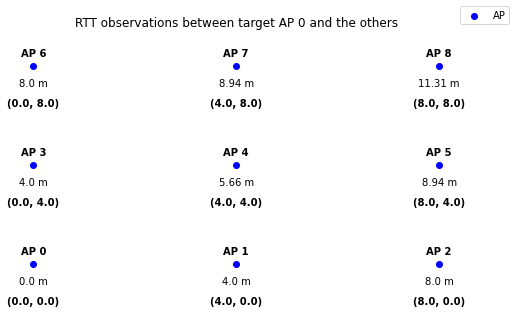

In [8]:
plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP '+menu.value+' and the others',pad=30)
plt.axis('off')

for x,y,z in zip(L_ap[:,0], L_ap[:,1], d_RTT[:,int(menu.value)]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"{(x,y)}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [9]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [10]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [11]:
"""
Surface fitting models
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 9.0, 1), np.arange(0.0, 9.0, 1))

#Models fitting and surface estimation
models_1 = np.array([surface_fit(L_ap, d_RTT[:,i]) for (i) in np.linspace(0, 8, 9).astype(int)])
models_2 = np.array([surface_fit(L_ap, d_RTT[:,i],2) for (i) in np.linspace(0, 8, 9).astype(int)])

Z_1 = np.array([sample_distance(X, Y, models_1[i]) for (i) in np.linspace(0, 8, 9).astype(int)])
Z_2 = np.array([sample_distance(X, Y, models_2[i]) for (i) in np.linspace(0, 8, 9).astype(int)])

In [12]:
##Select one AP to plot fitting model

In [13]:
menu_2 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_2

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

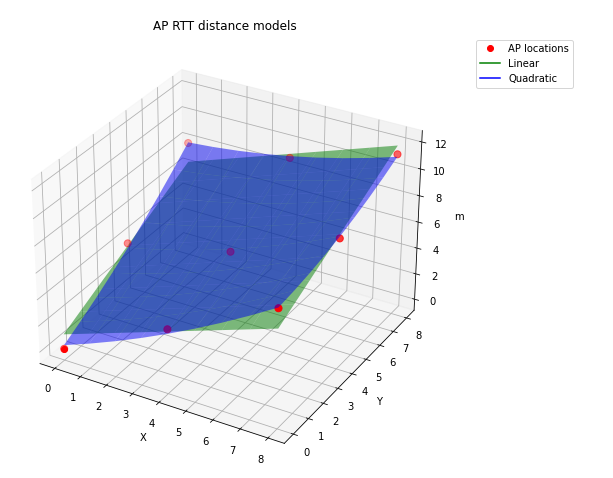

In [14]:
"""
Surface fitting plot
"""
fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[int(menu_2.value),:,:], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[int(menu_2.value),:,:], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT[:,int(menu_2.value)], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

ax.plot([0], [0], d_RTT[:,int(menu_2.value)][0], color="red", marker='o', linewidth=0)[0]
ax.plot([0], [0], color="green")[0]
ax.plot([0], [0], color="blue")[0]

fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [15]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (9,81,1))
fit_2 = np.reshape(Z_2, (9,81,1))

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and the rest
m_ap_1 = fit_1[:,[0,4,8,36,40,44,72,76,80],:]
m_ap_2 = fit_2[:,[0,4,8,36,40,44,72,76,80], :]
vrp_pts = np.delete(np.linspace(0, 80, 81).astype(int), [0,4,8,36,40,44,72,76,80], 0)

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and VRPs
m_vrp_1 = fit_1[:,vrp_pts,:]
m_vrp_2 = fit_2[:,vrp_pts,:]

In [16]:
##Select one AP to plot RTT Mean distances

In [17]:
menu_3 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_3

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

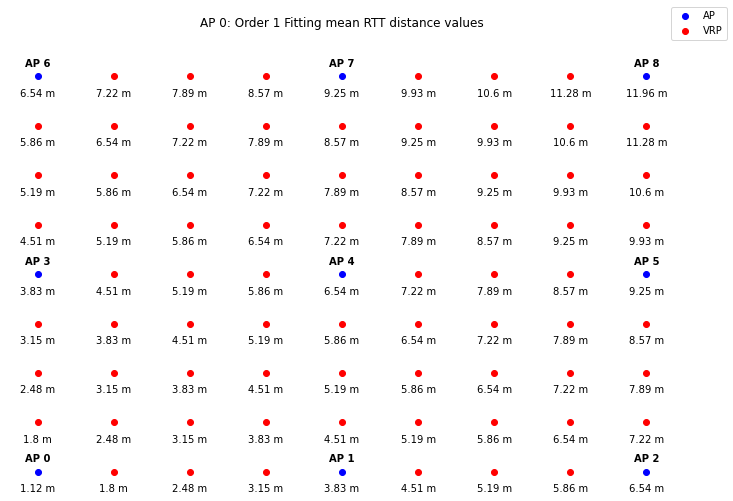

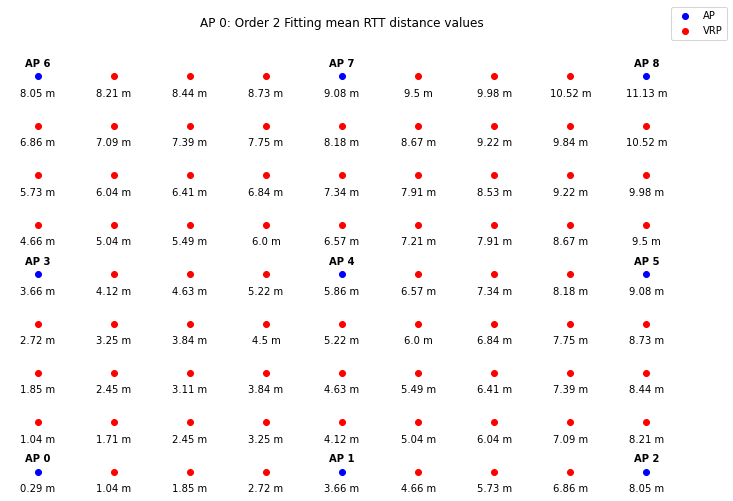

In [18]:
"""
Order 1 RTT Mean distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_3.value+': Order 1 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, models_1[int(menu_3.value)]).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

"""
Order 2 RTT Mean distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_3.value+': Order 2 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, models_2[int(menu_3.value)]).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [19]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [104]:
"""
Gaussian Process Definition using scikit-learn GPR
"""
sigma_n = 2.0

kernel = ConstantKernel(constant_value=1.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

In [105]:
class Regressor:
    '''
    Handles the required structures to compute GPR interpolation

            Parameters:
                    s_bar_star (ndarray): Predicted RTT distance at VRPs
                    s_var_star (ndarray): Predictions variance
                    m_ap (ndarray): Mean RTT distance values at AP locations from fitting model
                    m_vrp (ndarray): Mean RTT distance values at VRP locations from fitting model
    '''
    def __init__(self, _m_ap, _m_vrp, _s_bar_star, _s_var):
        self.m_ap = _m_ap
        self.m_vrp = _m_vrp
        self.s_bar_star = _s_bar_star
        self.s_var = _s_var

In [106]:
"""
Normalized Non-Zero Mean Gaussian Process Prediction

    loc --> AP locations
    d_rtt --> RTT distance observation
    ap_mean --> PSFM Mean RTT distance matrix
    vrp_mean --> PSFM Mean RTT distance matrix
"""
def gp_fit(loc, d_rtt, ap_mean, vrp_mean):
    
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    models = []
    y_pred = np.zeros(shape=(len(vrp_mean)))
    print(vrp_mean.shape)
    for (i) in np.linspace(0, 8, 9).astype(int):  
        norm = d_RTT[:,i].reshape(n,1) - ap_mean[i].reshape(n,1)
        model = gp.fit(loc, norm)
        y_pred, sigma = gp.predict(L_vrp, return_cov=True)
        mean_mat = np.zeros(shape=(i,i))
        if i==0:
            print(vrp_mean[i,:,:])
        if i==0:
            print(y_pred)
        y_pred = y_pred + vrp_mean[i,:,:]
        if i==0:
            print(y_pred)
        gpr = Regressor(ap_mean[i,:,:],vrp_mean[i,:,:],y_pred,np.diag(sigma))
        models.append(gpr)
    return models

In [107]:
"""
First Order PSFM GPR interpolation
"""
gpr_list = gp_fit(L_ap, d_RTT, m_ap_1, m_vrp_1)

(9, 72, 1)
[[ 1.79798978]
 [ 2.47540563]
 [ 3.15282148]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 1.79798978]
 [ 2.47540563]
 [ 3.15282148]
 [ 3.83023733]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 2.47540563]
 [ 3.15282148]
 [ 3.83023733]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 7.89473243]
 [ 3.15282148]
 [ 3.83023733]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 7.89473243]
 [ 8.57214828]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 7.21731658]
 [ 7.89473243]
 [ 8.57214828]
 [ 4.50765318]
 [ 5.18506903]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 7.89473243]
 [ 8.57214828]
 [ 9.24956413]
 [ 9.92697998]
 [ 5.18506903]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 7.89473243]
 [ 8.57214828]
 [ 9.24956413]
 [ 9.92697998]
 [10.60439583]
 [ 5.86248488]
 [ 6.53990073]
 [ 7.21731658]
 [ 7.89473243]
 [ 8.57214828]
 [ 9.24956413]
 [ 9.92697998]
 [10.60439583]
 [11.28181168]

In [108]:
"""
Second Order PSFM GPR interpolation
"""
gpr_list_2 = gp_fit(L_ap, d_RTT, m_ap_2, m_vrp_2)

(9, 72, 1)
[[ 1.03602196]
 [ 1.84717852]
 [ 2.72199609]
 [ 4.66261423]
 [ 5.7284148 ]
 [ 6.85787637]
 [ 1.03602196]
 [ 1.71029422]
 [ 2.44822748]
 [ 3.24982174]
 [ 4.115077  ]
 [ 5.04399327]
 [ 6.03657053]
 [ 7.0928088 ]
 [ 8.21270807]
 [ 1.84717852]
 [ 2.44822748]
 [ 3.11293743]
 [ 3.84130839]
 [ 4.63334035]
 [ 5.48903331]
 [ 6.40838727]
 [ 7.39140223]
 [ 8.4380782 ]
 [ 2.72199609]
 [ 3.24982174]
 [ 3.84130839]
 [ 4.49645604]
 [ 5.21526469]
 [ 5.99773435]
 [ 6.84386501]
 [ 7.75365667]
 [ 8.72710933]
 [ 4.115077  ]
 [ 4.63334035]
 [ 5.21526469]
 [ 6.57009639]
 [ 7.34300375]
 [ 8.1795721 ]
 [ 4.66261423]
 [ 5.04399327]
 [ 5.48903331]
 [ 5.99773435]
 [ 6.57009639]
 [ 7.20611944]
 [ 7.90580349]
 [ 8.66914854]
 [ 9.49615459]
 [ 5.7284148 ]
 [ 6.03657053]
 [ 6.40838727]
 [ 6.84386501]
 [ 7.34300375]
 [ 7.90580349]
 [ 8.53226423]
 [ 9.22238598]
 [ 9.97616873]
 [ 6.85787637]
 [ 7.0928088 ]
 [ 7.39140223]
 [ 7.75365667]
 [ 8.1795721 ]
 [ 8.66914854]
 [ 9.22238598]
 [ 9.83928442]
 [10.51984386]

In [109]:
##Select one AP to plot Gaussian Process Interpolations

In [110]:
menu_5 = widgets.Dropdown(
       options=['0', '1', '2', '3', '4', '5', '6', '7', '8'],
       value='0',
       description='AP:')
menu_5

Dropdown(description='AP:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8'), value='0')

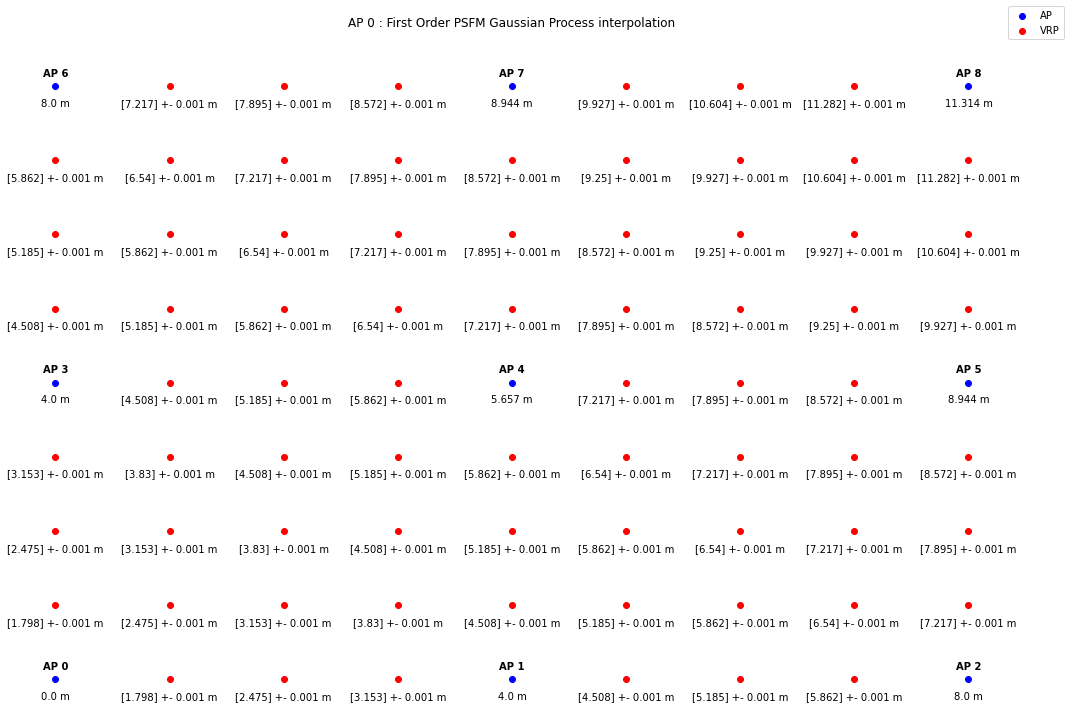

In [111]:
"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_5.value+' : First Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT[int(menu_5.value)])):
    label = f"{d_RTT[int(menu_5.value),x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(gpr_list[int(menu_5.value)].s_bar_star)):
    label = f"{gpr_list[int(menu_5.value)].s_bar_star[x].round(3)} +- {gpr_list[int(menu_5.value)].s_var[x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

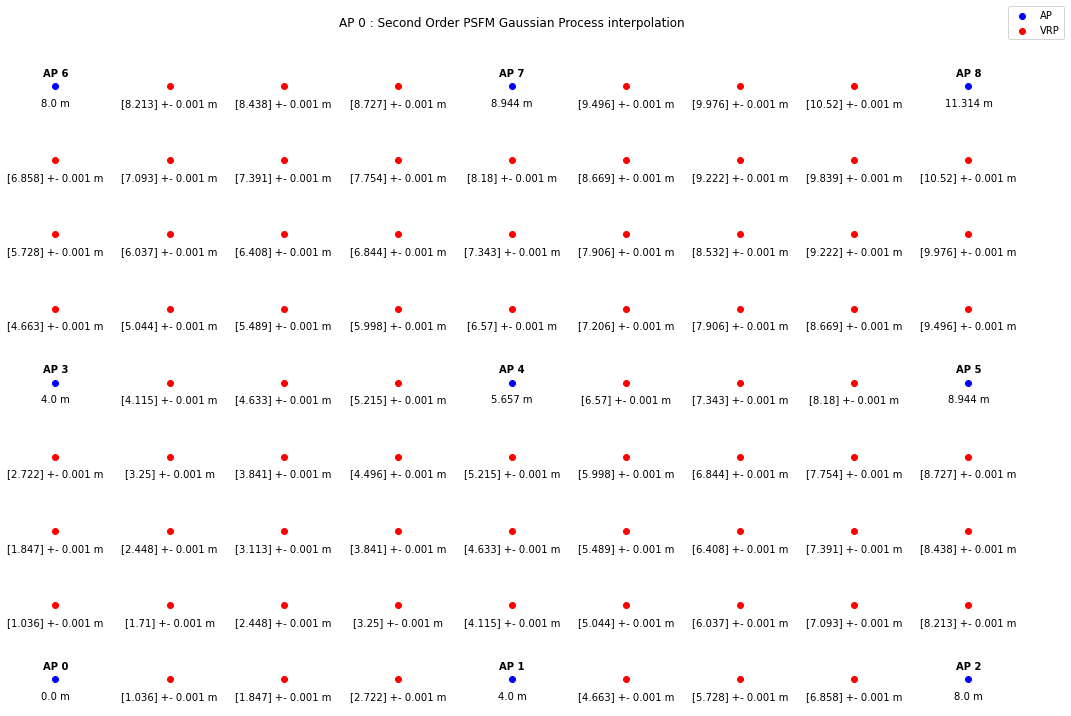

In [112]:
"""
Second Order Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('AP '+menu_5.value+' : Second Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT[int(menu_5.value)])):
    label = f"{d_RTT[int(menu_5.value),x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(gpr_list_2[int(menu_5.value)].s_bar_star)):
    label = f"{gpr_list_2[int(menu_5.value)].s_bar_star[x].round(3)} +- {gpr_list_2[int(menu_5.value)].s_var[x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(L_ap[:,0],L_ap[:,1], np.linspace(0, 8, 9).astype(int)):

    label = f"AP {z}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

In [113]:
print(m_ap_1[1])
print(d_RTT[1])

test = d_RTT[:,1].reshape(9,1)-m_ap_1[1].reshape(9,1)
print(test)

[[2.48549295]
 [2.48549295]
 [2.48549295]
 [5.46691692]
 [5.46691692]
 [5.46691692]
 [8.44834089]
 [8.44834089]
 [8.44834089]]
[4.         0.         4.         5.65685425 4.         5.65685425
 8.94427191 8.         8.94427191]
[[ 1.51450705]
 [-2.48549295]
 [ 1.51450705]
 [ 0.18993733]
 [-1.46691692]
 [ 0.18993733]
 [ 0.49593102]
 [-0.44834089]
 [ 0.49593102]]


In [114]:
gp.fit(L_ap, test)

GaussianProcessRegressor(alpha=4.0, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [115]:
prediction, sigma = gp.predict([[0, 1]], return_std=True)

In [116]:
print(gp.get_params())

{'alpha': 4.0, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (0.001, 1000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


In [117]:
print(prediction)
print(sigma)

[[2.84964959e-05]]
[0.03162275]
